# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 46071/46071 [00:59<00:00, 776.66it/s]


In [23]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

# [4] Featurization

In [25]:
type(np.array(preprocessed_reviews))

numpy.ndarray

In [26]:
# splitting of data into train and test

import math

preprocessed_reviews = np.array(preprocessed_reviews)
train_size = math.floor(preprocessed_reviews.shape[0]*0.7)

preprocessed_reviews_train = preprocessed_reviews[:train_size]
preprocessed_reviews_test = preprocessed_reviews[train_size:]
Score_train = final["Score"][:train_size]
Score_test = final["Score"][train_size:]
print(preprocessed_reviews_train.shape)
print(preprocessed_reviews_test.shape)
print(Score_train.shape)
print(Score_test.shape)

(32249,)
(13822,)
(32249,)
(13822,)


## [4.1] BAG OF WORDS

In [27]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(preprocessed_reviews_train)
X_test_counts = count_vect.transform(preprocessed_reviews_test)
print(count_vect.get_feature_names()[:10])

['aa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aachen', 'aadp', 'aafco', 'aahs']


In [28]:
# finding the hyperparameter C using gridsearch
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(final_counts[0:20000], Score_train[0:20000])
print(model.best_estimator_)

c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


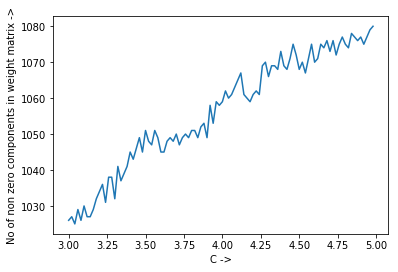

In [29]:
# Sparsity in vector using l1 regularization
from sklearn.cross_validation import cross_val_score
values =list(np.arange(3,5,0.02))
cv_score =[]
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l1')
    lr.fit(final_counts[0:5000],Score_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('No of non zero components in weight matrix ->')
plt.show()


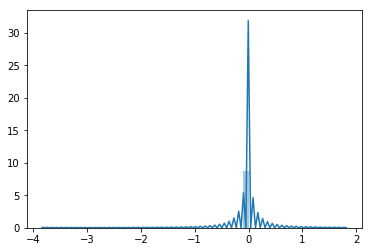

In [30]:
# Multicolinearity check using l1 regularization
mat = np.random.normal(loc=0.1,scale = 0.1 ,size=1000)
mat = mat.reshape(1000,1)
lcheck = LogisticRegression(C=4.96,penalty='l1')
lcheck.fit(final_counts[0:1000],Score_train[0:1000])
lcheck = LogisticRegression(C=4.96,penalty='l1')
lcheck.fit(final_counts[0:1000],Score_train[0:1000])
noise = final_counts[0:1000] + mat
lcheck1 = LogisticRegression(C=4.96,penalty='l1')
lcheck1.fit(noise,Score_train[0:1000])
w1 = np.array(lcheck.coef_)
w2 = np.array(lcheck1.coef_)
weight = np.subtract(w1,w2)
weight = pd.DataFrame(data=weight.T,index=None)
sns.distplot(a=weight,kde=True)
plt.show();

In [31]:
# Best C using gridsearch and l2 regularization
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l2')
l2_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(logisticregression, l2_values, scoring = 'f1', cv=10)
model.fit(final_counts[0:20000], Score_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


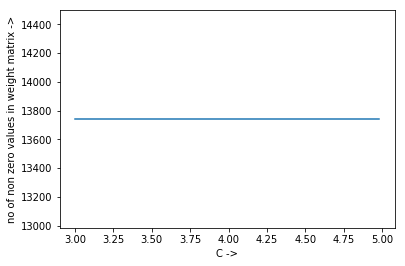

In [32]:
# Sparsity in weight matrix due to l2 regularization
from sklearn.cross_validation import cross_val_score
values =list(np.arange(3,5,0.02))
cv_score =[]
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l2')
    lr.fit(final_counts[0:5000],Score_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('no of non zero values in weight matrix ->')
plt.show()

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logisticclassifier = LogisticRegression(C=4.86,penalty='l1')
logisticclassifier.fit(final_counts[0:90000],Score_train[0:90000])
Score_predicted = logisticclassifier.predict(X_test_counts[0:10000])
score = accuracy_score(Score_predicted,Score_test[0:10000])
con = confusion_matrix(Score_test[0:10000],Score_predicted)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  89.35 %
confusion matrix
[[1255  543]
 [ 522 7680]]


In [34]:
from sklearn.metrics import accuracy_score
logisticclassifier = LogisticRegression(C=4.86,penalty='l1')
logisticclassifier.fit(final_counts[0:90000],Score_train[0:90000])
Score_predicted = logisticclassifier.predict(final_counts[0:10000])
score = accuracy_score(Score_predicted,Score_train[0:10000])
print('accuracy on training data: ',score*100,"%")

accuracy on training data:  99.39 %


In [35]:
##################       Finding top features according to logistic regression   ####################
feature_names = count_vect.get_feature_names()
feature_names = np.array(feature_names)
feature = np.vstack((np.absolute(logisticclassifier.coef_),feature_names))
feature = pd.DataFrame(data=feature.T,columns=('coefficients','words'))
main = feature.sort_values('coefficients', axis=0, ascending=False, inplace=False, kind='quicksort')
print('\t     top 20 features')
print(main[0:20])

	     top 20 features
                coefficients       words
7471       9.991902863054522   deceptive
32395       9.74392172214139    whomever
7552       9.337348140663233     defeats
9167       9.287041441728336     eagerly
16975  9.257982116610895e-06      longer
8855       9.138296445451461   downright
6993       8.886773137132742    crunchie
31987      8.697327649381872      warmed
20846      8.640515517008836        pant
31473       8.18692116107783       veggi
27311      8.151060061017063  specialist
7819       8.143451553859252     depicts
24018  8.101411629943714e-05     regular
21235      8.043875775652834      pencil
7666       8.008243040779625  delicately
13614      7.846482632284795       hempy
12911       7.74904239325672     grossed
14320      7.566099401193982  identified
31510      7.506886065582288        vent
16619      7.487649598254763   liberally


## [4.3] TF-IDF

In [36]:
tf_idf_vect=TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(preprocessed_reviews_train)
final_tf_idf_xtest= tf_idf_vect.transform(preprocessed_reviews_test)
print(tf_idf_vect.get_feature_names()[:10])

['aa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aachen', 'aadp', 'aafco', 'aahs']


In [37]:
# Using gridsearch
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(final_tf_idf[0:20000], Score_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [38]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l2')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
model.fit(final_tf_idf[0:20000], Score_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


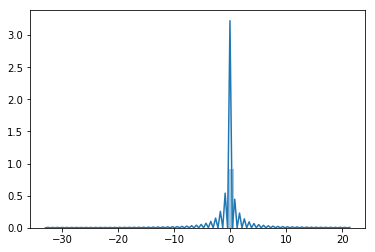

In [39]:
noise = np.random.normal(loc=0.1,scale=0.1,size=100)
noise = noise.reshape(100,1)
noise_counts = final_tf_idf[0:100] + noise
l1 = LogisticRegression(C=100,penalty='l1')
l1.fit(final_tf_idf[0:100],Score_train[0:100])
l2 = LogisticRegression(C=100,penalty='l1')
l2.fit(noise_counts,Score_train[0:100])
weights = np.array(l1.coef_)
weight_noise = np.array(l2.coef_)
weight = np.subtract(weights,weight_noise)
sns.distplot(a=weight,kde=True)
plt.show()

In [40]:
model = LogisticRegression(C=100,penalty='l1')
model.fit(final_tf_idf[0:40000],Score_train[0:40000])
pred = model.predict(final_tf_idf_xtest[0:8000])
acc = accuracy_score(Score_test[0:8000],pred)
con = confusion_matrix(Score_test[0:8000],pred)
print('accuracy on test data: ',acc*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  88.53750000000001 %
confusion matrix
[[ 997  463]
 [ 454 6086]]


In [41]:
model = LogisticRegression(C=100,penalty='l1')
model.fit(final_tf_idf[0:40000],Score_train[0:40000])
pred = model.predict(final_tf_idf[0:8000])
acc = accuracy_score(Score_train[0:8000],pred)
print('accuracy on training data',acc*100)

accuracy on training data 99.97500000000001


In [42]:

features = tf_idf_vect.get_feature_names()
feature = np.array(features)
features = np.vstack((features,np.absolute(model.coef_)))
features = pd.DataFrame(data=features.T,columns=('words','coefficients'))
main = features.sort_values('coefficients',axis=0,inplace=False,ascending=False,kind='quicksort')
print('\t top tf_idf features ')
print(main[0:20])

	 top tf_idf features 
            words       coefficients
31278         use   9.99997508921353
201        acetic  9.998302345097644
26530       sized  9.995801722595965
7164       custom  9.992612319529721
20875     paprika  9.991876183017677
17562       mario  9.989625005433263
28005  storebrand  9.989298038657145
4523       caused  9.986401463750028
5235      chronic    9.9761947825842
21825       plane  9.972583062218225
440    advertized  9.968795325405654
17569      marked  9.958818685117246
19610  noticeable  9.953468717879296
24952      rotten   9.95243750739185
18560       moldy  9.952275013568622
3361       braces  9.952089795007993
18388    mislabel  9.951183548489945
12781     greatly  9.948359696330387
5367        claim  9.947085425184094
2284    basements   9.93991841398245


## [4.4] Word2Vec

In [43]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews_train:
    list_of_sentance.append(sentance.split())

In [44]:
len(list_of_sentance)

32249

In [45]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in preprocessed_reviews_test:
    list_of_sentance_test.append(sentance.split())

In [46]:
len(list_of_sentance_test)

13822

In [47]:
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

[('awesome', 0.8551010489463806), ('fantastic', 0.8225057125091553), ('amazing', 0.788281261920929), ('terrific', 0.7872094511985779), ('excellent', 0.7859882116317749), ('good', 0.7754828333854675), ('wonderful', 0.7523402571678162), ('perfect', 0.7514618039131165), ('decent', 0.6979030966758728), ('nice', 0.6656449437141418)]
[('best', 0.7720878720283508), ('experienced', 0.7173752188682556), ('ive', 0.6956747174263), ('eaten', 0.6939854621887207), ('tastiest', 0.6828915476799011), ('greatest', 0.6724961400032043), ('closest', 0.651867151260376), ('nicest', 0.6209477186203003), ('superior', 0.6208013892173767), ('encountered', 0.6192030906677246)]


In [48]:
if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
    print(w2v_model_test.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_test.wv.most_similar('worst'))

[('good', 0.8438169956207275), ('excellent', 0.8341026902198792), ('decent', 0.7355610728263855), ('awesome', 0.7293555736541748), ('wonderful', 0.7289249897003174), ('amazing', 0.7058644890785217), ('fantastic', 0.6909414529800415), ('delicious', 0.6847807168960571), ('well', 0.6734513640403748), ('super', 0.6695624589920044)]
[('closest', 0.9196714758872986), ('vita', 0.9090338349342346), ('strongest', 0.9090232849121094), ('hooked', 0.905957818031311), ('nastiest', 0.9046236276626587), ('admit', 0.8992438912391663), ('colada', 0.8979972004890442), ('mediocre', 0.8921833038330078), ('connoisseur', 0.8906532526016235), ('horrible', 0.8884634971618652)]


In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10817
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


In [50]:
w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  6827
sample words  ['found', 'diet', 'foods', 'site', 'got', 'come', 'amazon', 'first', 'price', 'lower', 'prime', 'shipping', 'get', 'much', 'faster', 'use', 'scoop', 'gives', 'great', 'cup', 'hot', 'chocolate', 'high', 'protein', 'help', 'like', 'lost', 'lbs', 'months', 'not', 'terribly', 'fast', 'weight', 'loss', 'hungry', 'trying', 'maintain', 'last', 'six', 'substituting', 'meals', 'shakes', 'helps', 'enjoy', 'drinking', 'drinks', 'allows', 'savor', 'longer', 'skeptical']


## Converting text into vectors using Avg W2V

#### Avg W2v

In [51]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 32249/32249 [04:14<00:00, 126.57it/s]


32249
50


In [52]:
sent_vectors_xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_xtest.append(sent_vec)
print(len(sent_vectors_xtest))
print(len(sent_vectors_xtest[0]))

100%|███████████████████████████████████| 13822/13822 [01:07<00:00, 203.84it/s]


13822
50


In [53]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(sent_vectors[0:20000], Score_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [54]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
model.fit(sent_vectors[0:20000], Score_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [55]:
from sklearn.metrics import accuracy_score
logisticregression = LogisticRegression(C=1 , penalty='l1')
logisticregression.fit(sent_vectors[0:90000],Score_train[0:90000])
pred = logisticregression.predict(sent_vectors_xtest[0:20000])
score = accuracy_score(Score_test[0:20000],pred)
con = confusion_matrix(Score_test[0:20000],pred)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  75.22789755462307 %
confusion matrix
[[ 860 1515]
 [1909 9538]]


In [56]:
from sklearn.metrics import accuracy_score
logisticregression = LogisticRegression(C=1 , penalty='l2')
logisticregression.fit(sent_vectors[0:90000],Score_train[0:90000])
pred = logisticregression.predict(sent_vectors_xtest[0:20000])
score = accuracy_score(Score_test[0:20000],pred)
con = confusion_matrix(Score_test[0:20000],pred)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  75.03255679351759 %
confusion matrix
[[ 864 1511]
 [1940 9507]]


In [57]:
logisticregression = LogisticRegression(C=1 , penalty='l2')
logisticregression.fit(sent_vectors[0:90000],Score_train[0:90000])
pred = logisticregression.predict(sent_vectors[0:90000])
score = accuracy_score(Score_train[0:90000],pred)
print('accuracy on training data:',score*100)

accuracy on training data: 88.13916710595677


In [58]:
logisticregression = LogisticRegression(C=1 , penalty='l1')
logisticregression.fit(sent_vectors[0:90000],Score_train[0:90000])
pred = logisticregression.predict(sent_vectors[0:90000])
score = accuracy_score(Score_train[0:90000],pred)
print('accuracy on training data:',score*100)

accuracy on training data: 88.13606623461192
